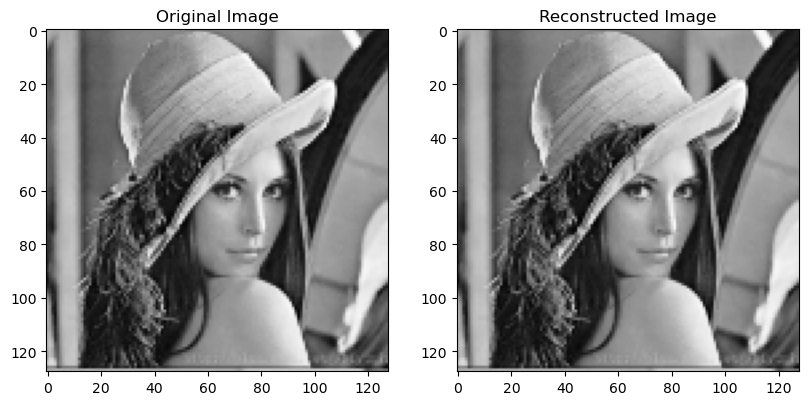

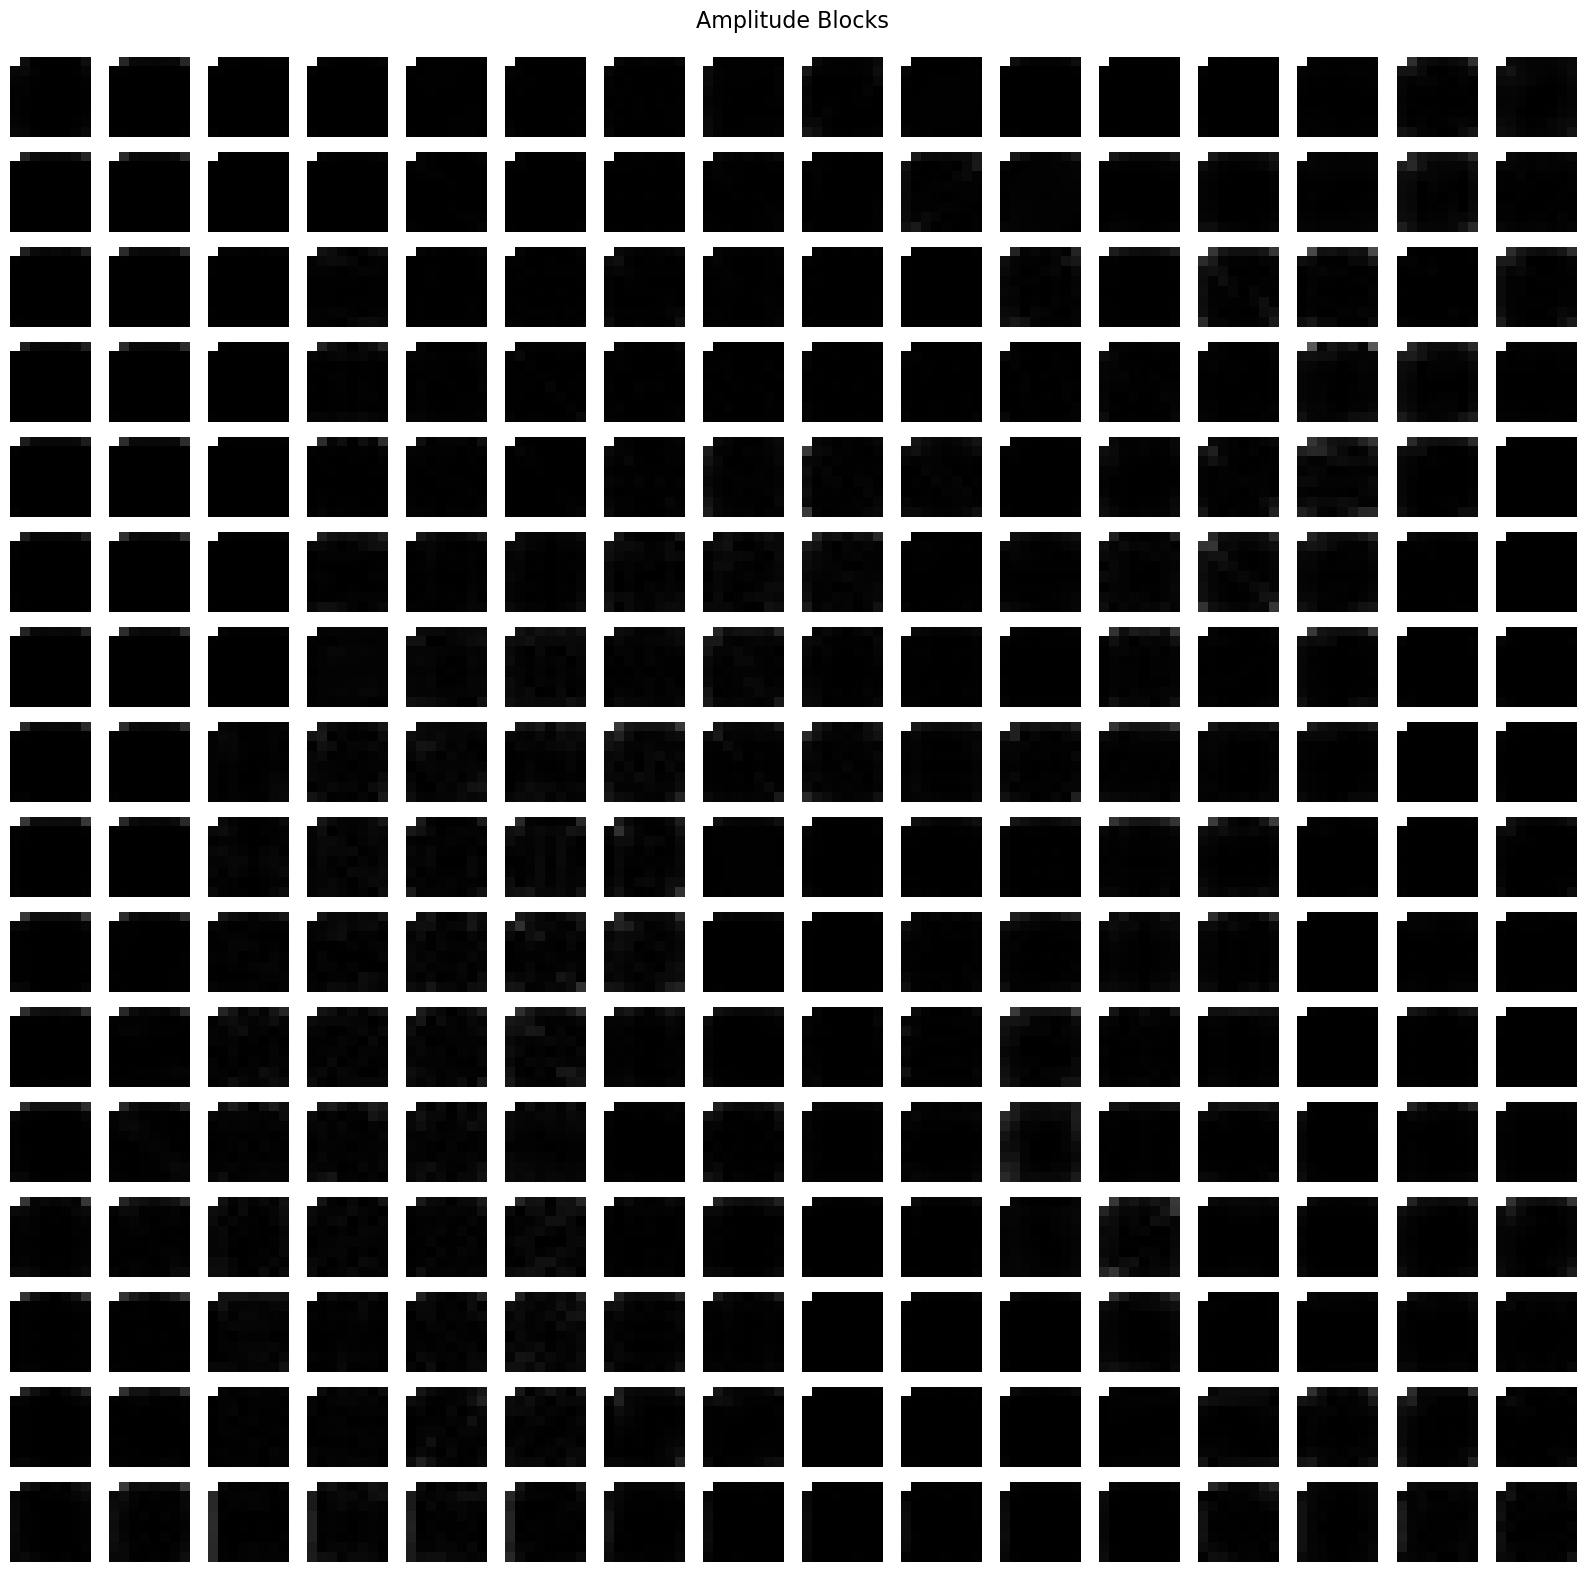

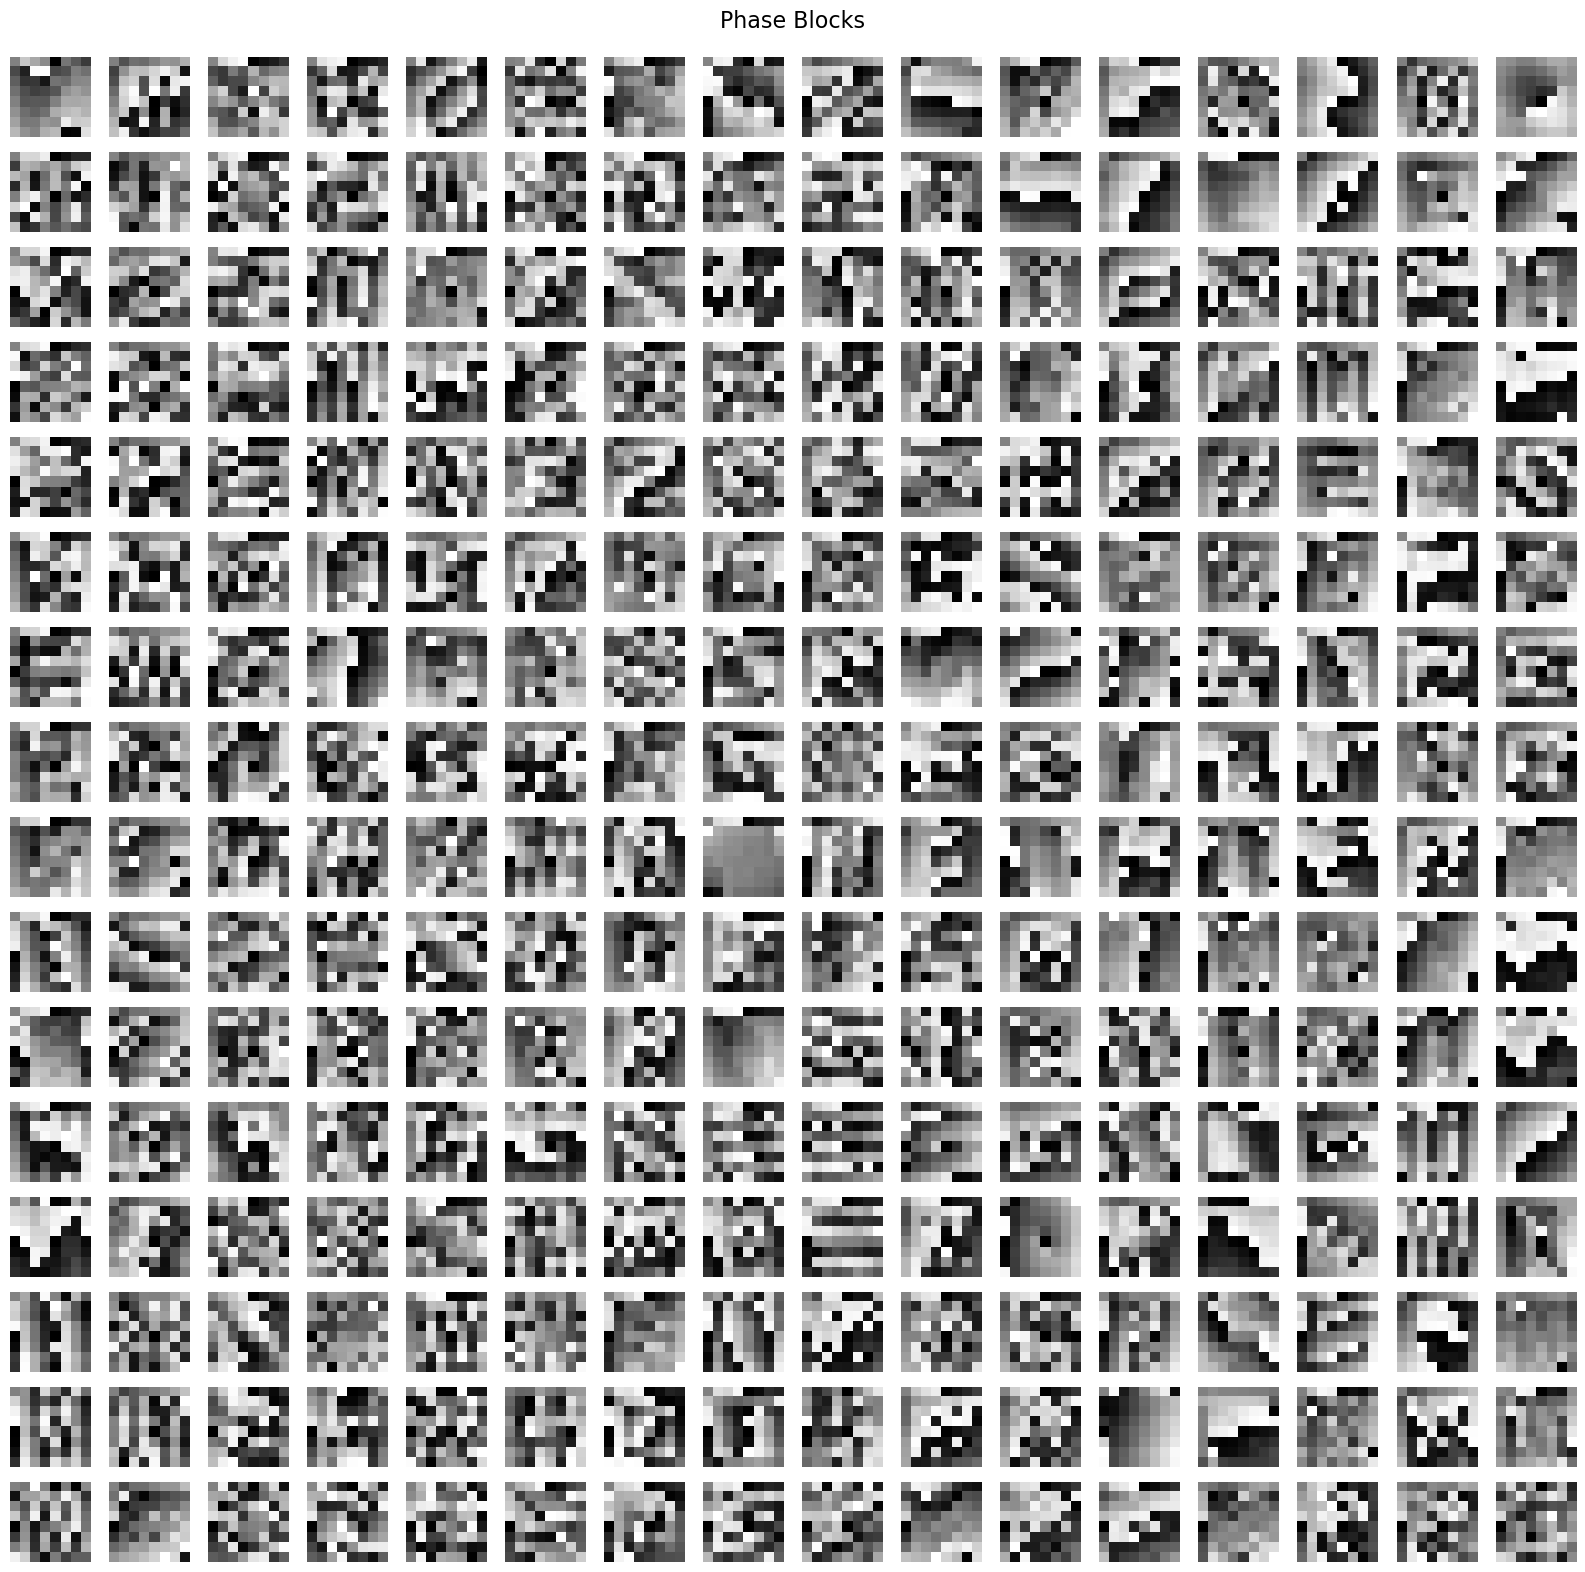

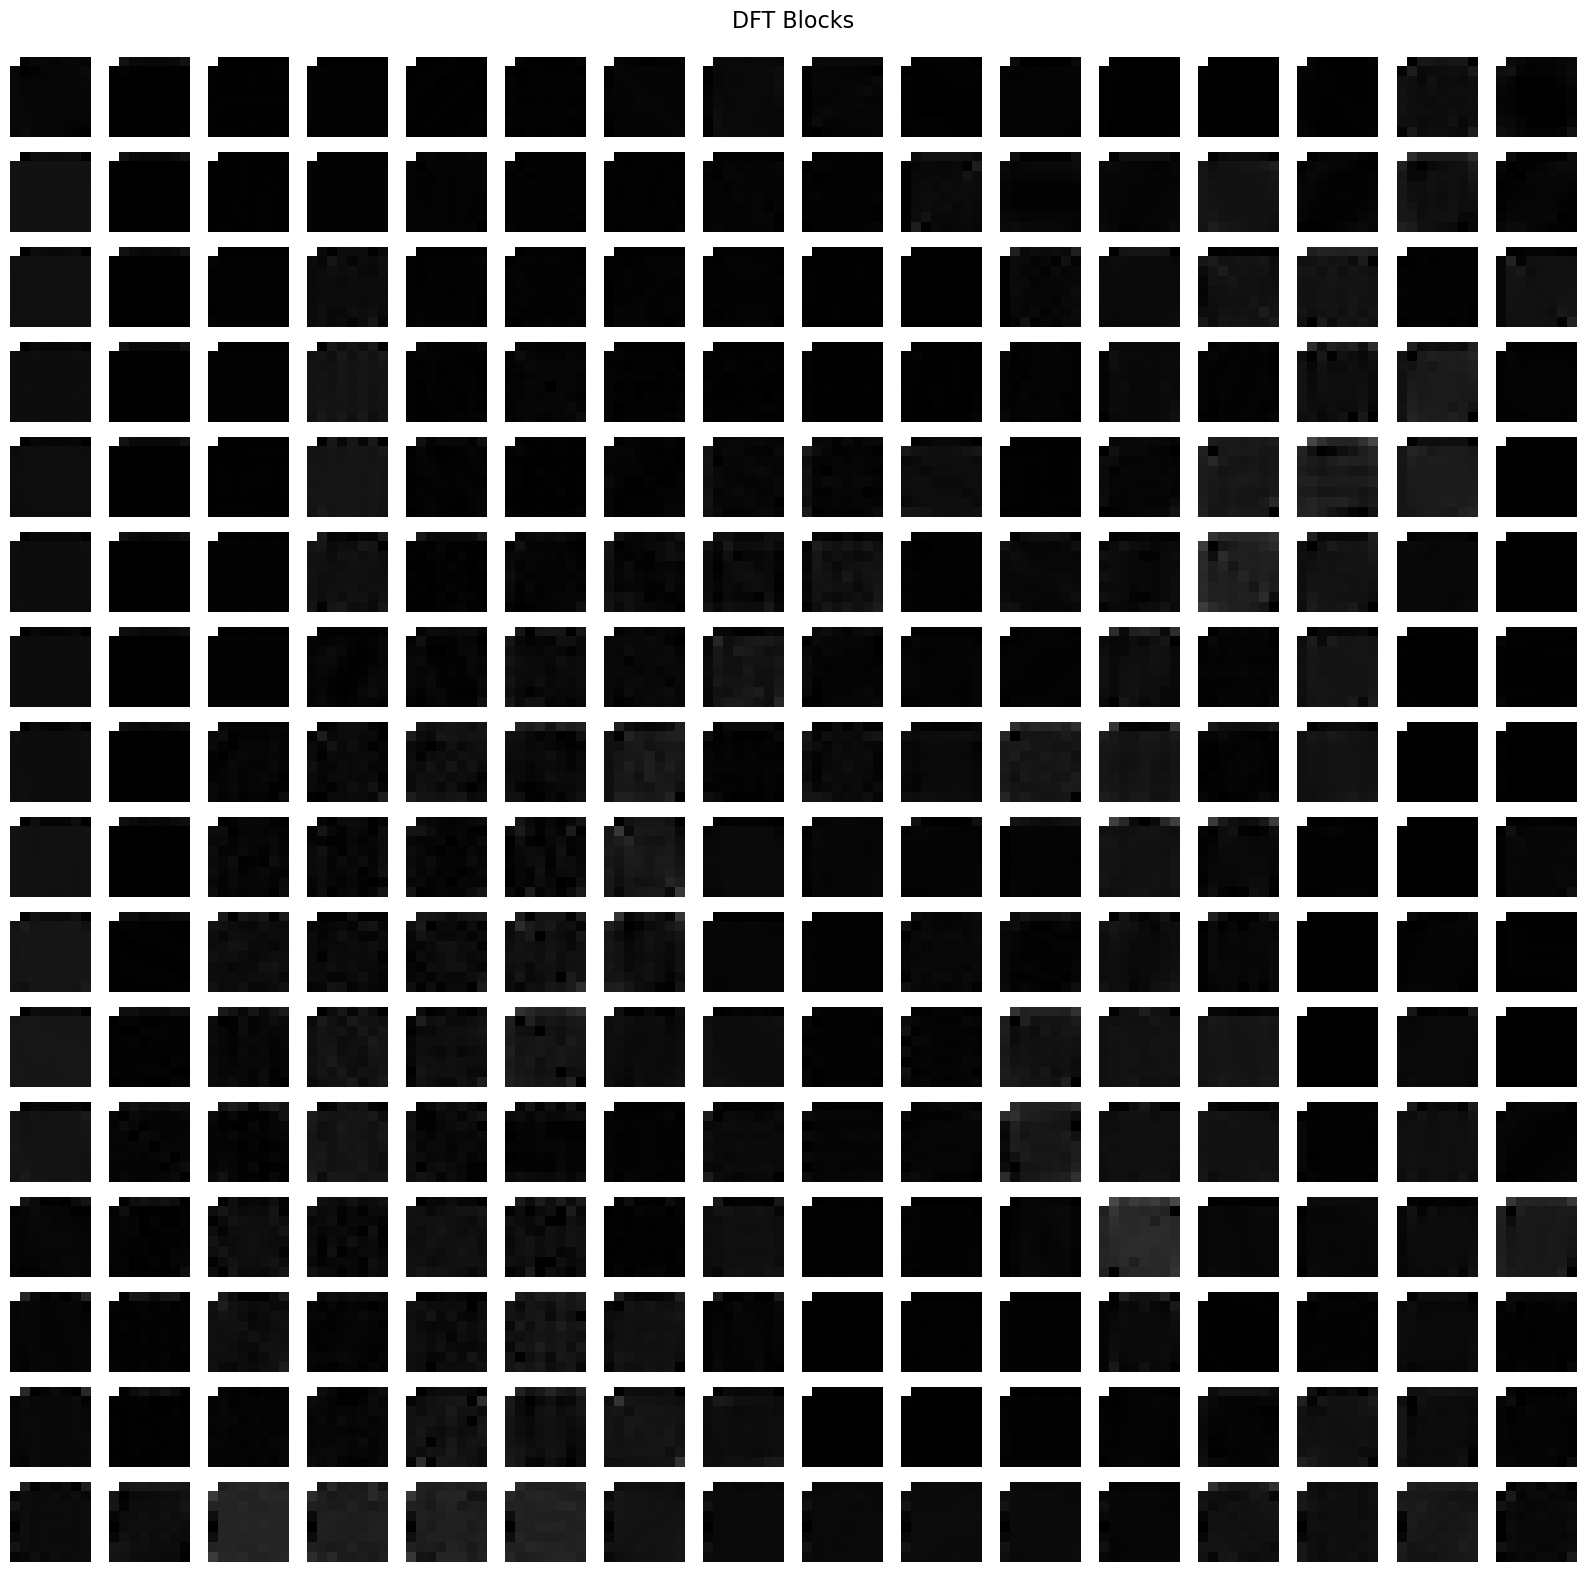

<Figure size 640x480 with 0 Axes>

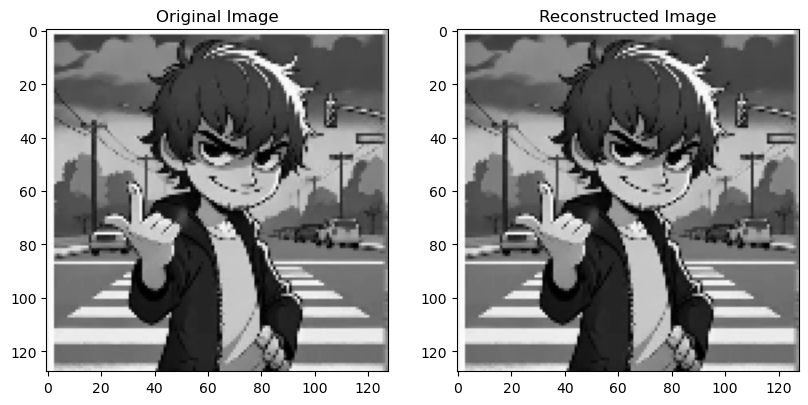

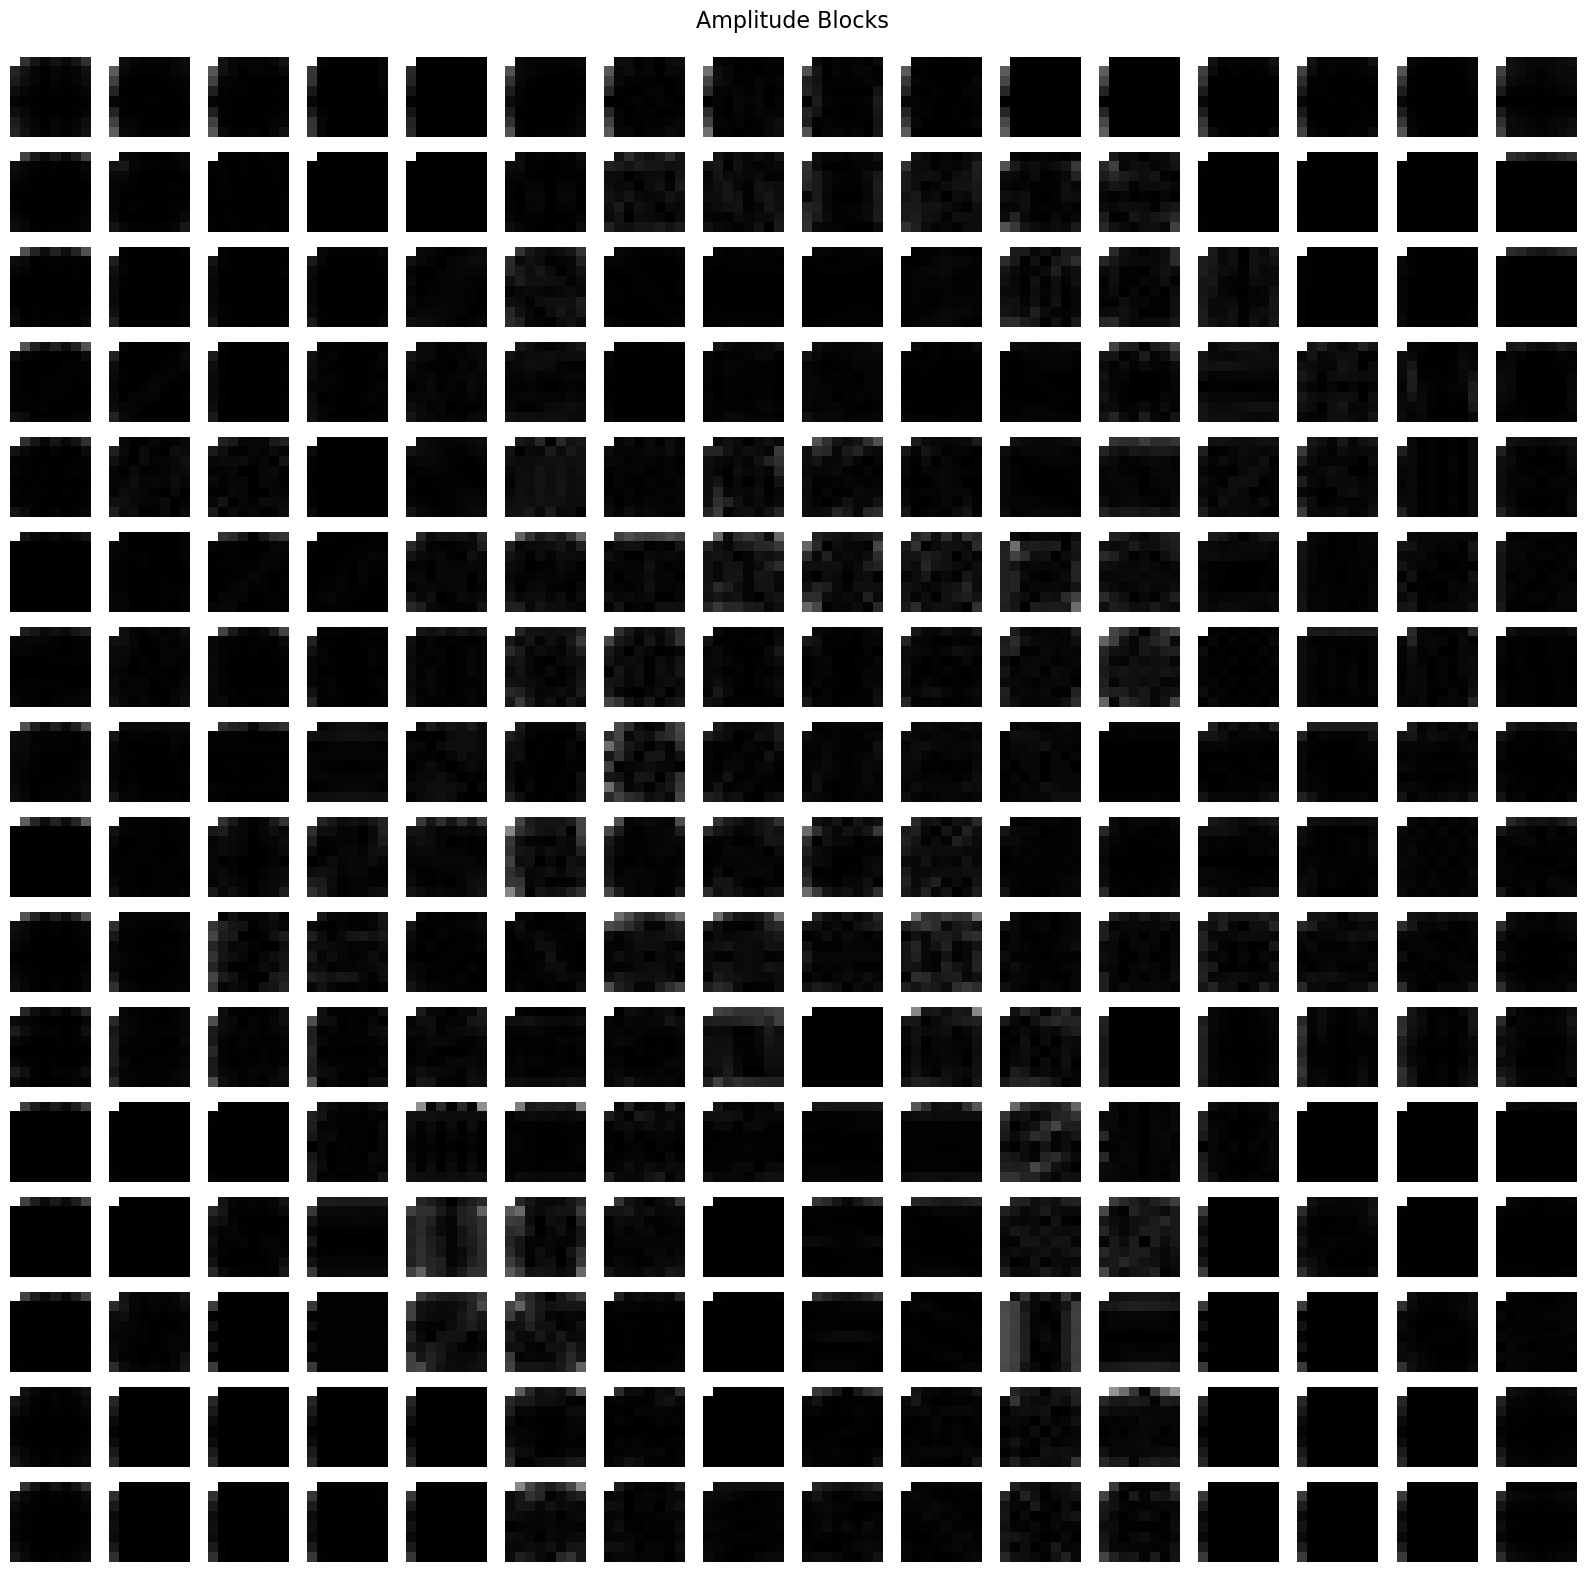

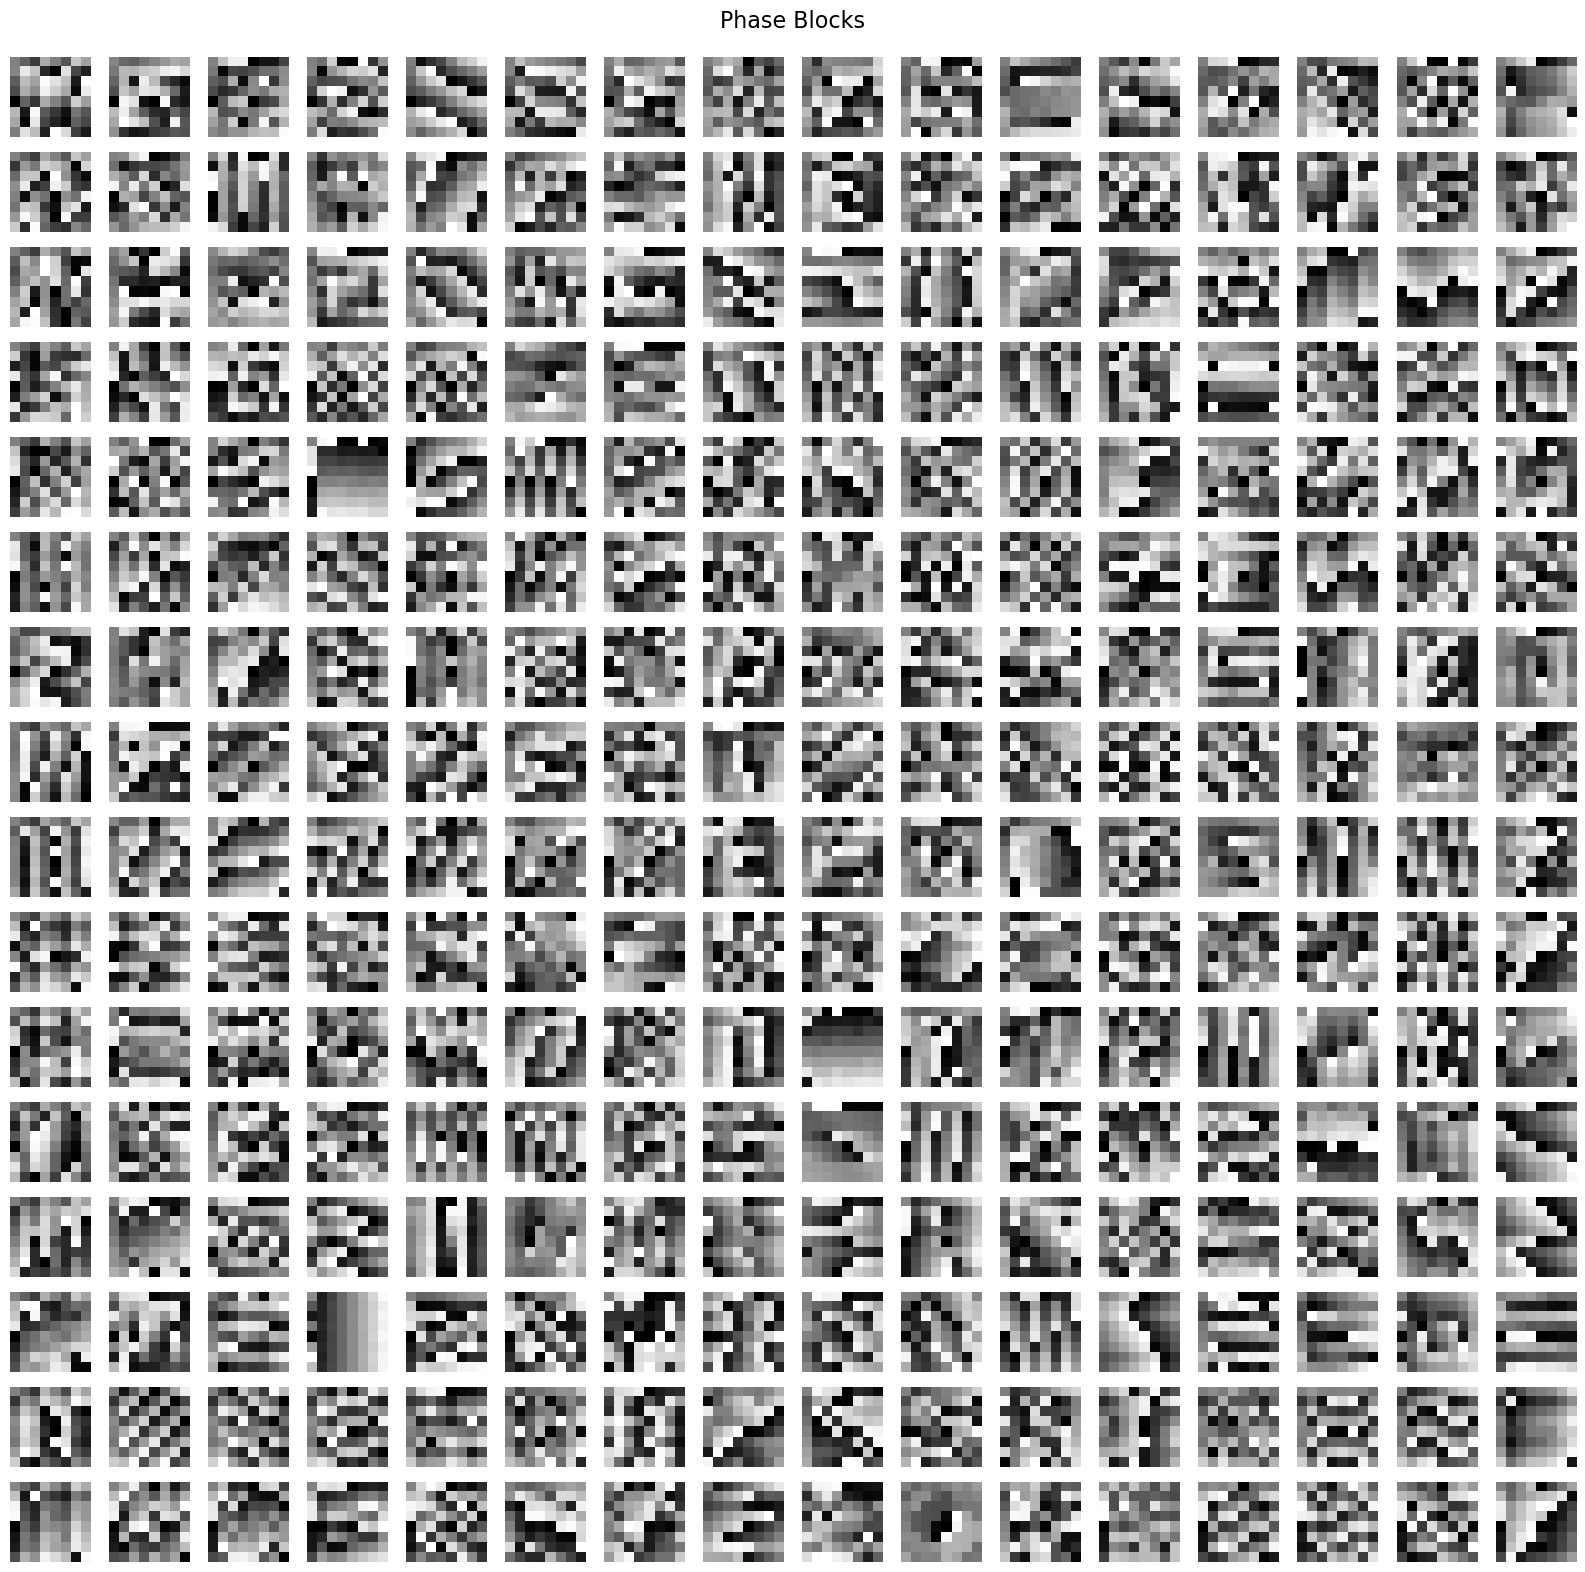

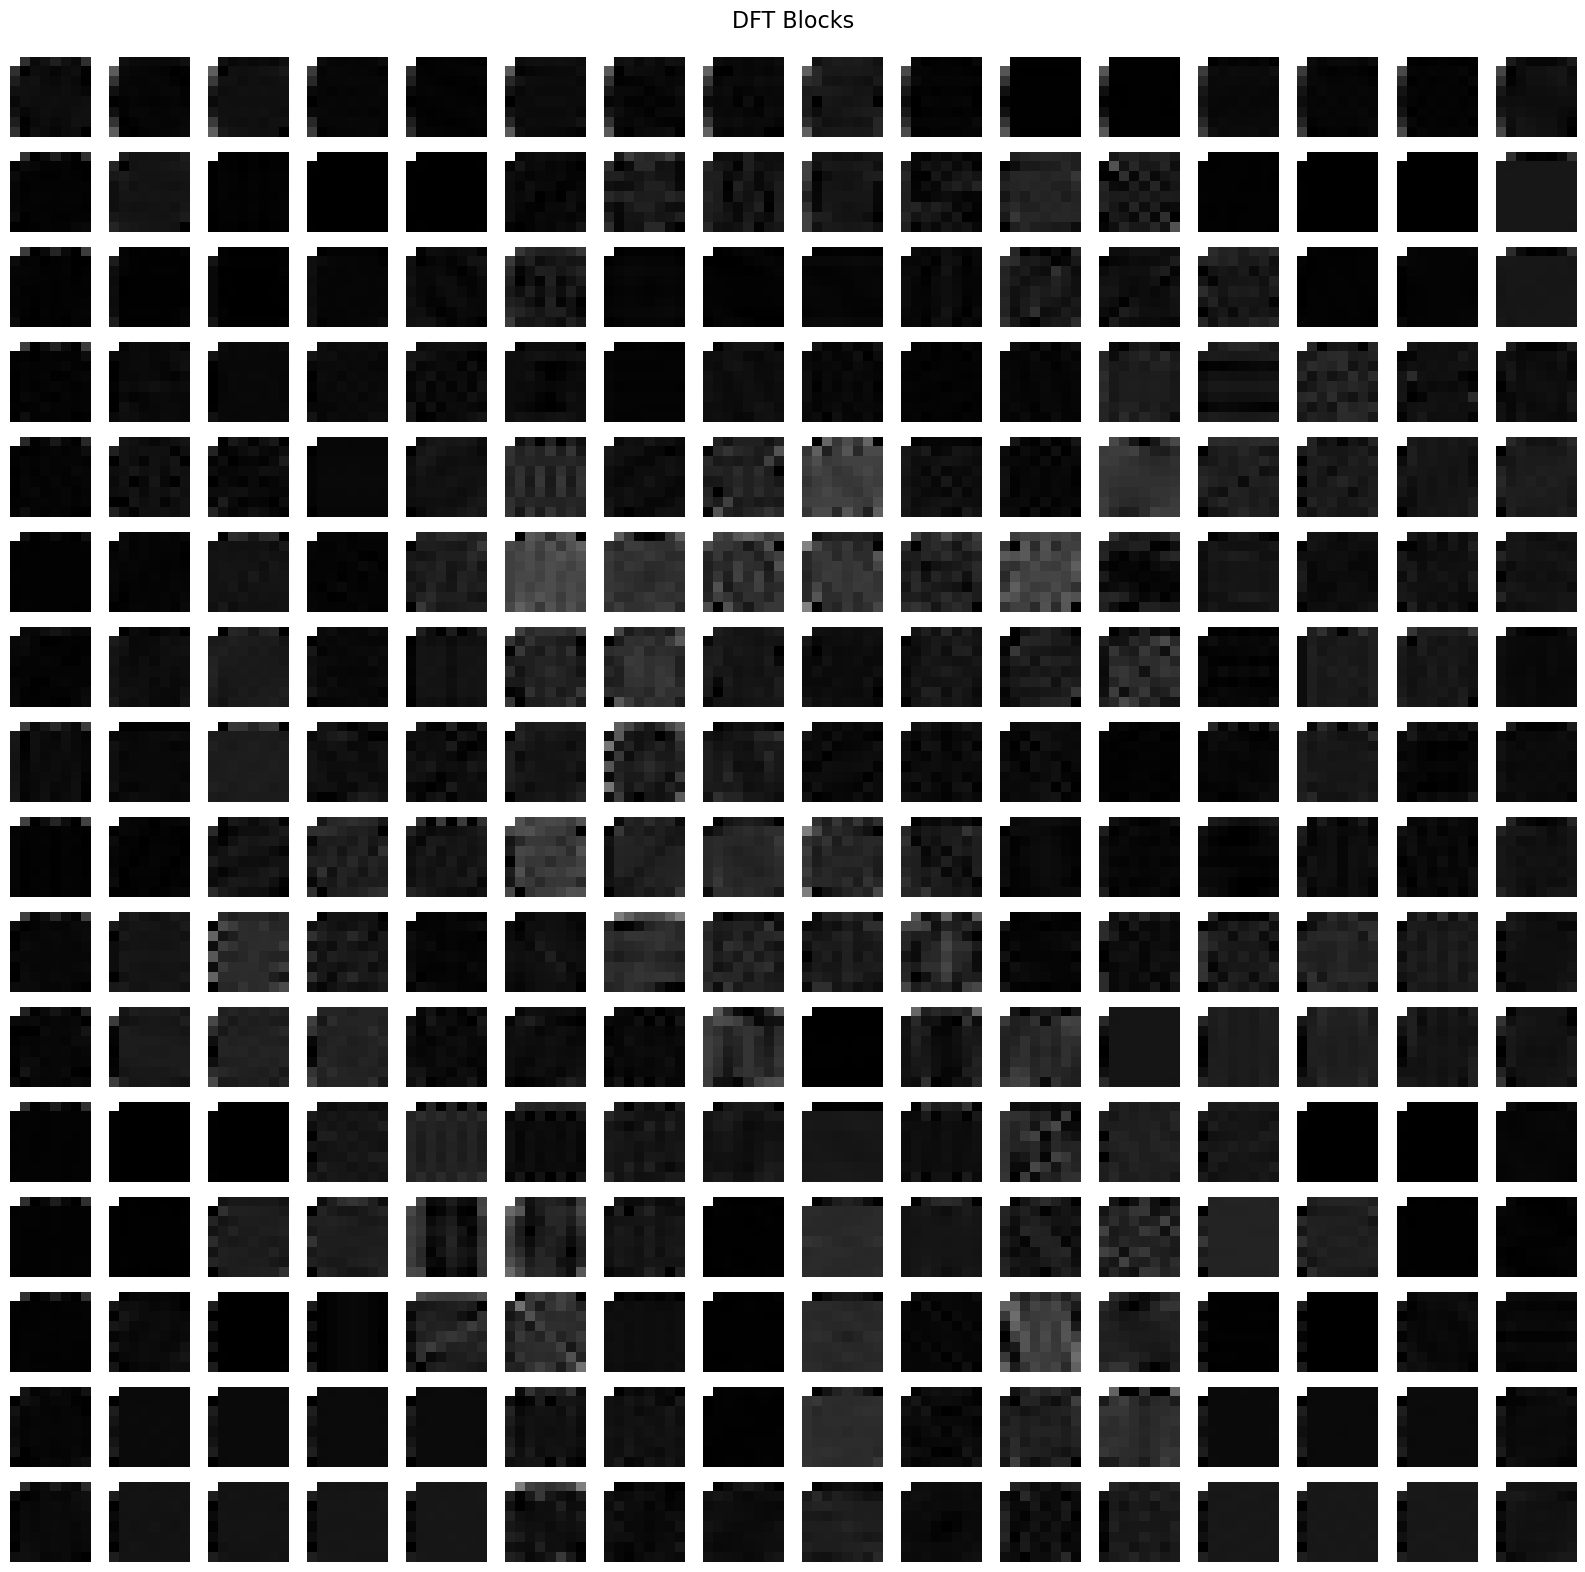

<Figure size 640x480 with 0 Axes>

In [3]:
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np

def preprocess_dft_kernel(M, N):
    dft_kernel = [[[[0+0j for _ in range(N)] for _ in range(M)] for _ in range(N)] for _ in range(M)]
    for u in range(M):
        for v in range(N):
            for x in range(M):
                for y in range(N):
                    dft_kernel[u][v][x][y] = np.exp(-2j * math.pi * ((u * x) / M + (v * y) / N))
    return dft_kernel

def preprocess_idft_kernel(M, N):
    dft_kernel = [[[[0+0j for _ in range(N)] for _ in range(M)] for _ in range(N)] for _ in range(M)]
    for u in range(M):
        for v in range(N):
            for x in range(M):
                for y in range(N):
                    dft_kernel[u][v][x][y] = np.exp(2j * math.pi * ((u * x) / M + (v * y) / N))
    return dft_kernel    

def dft_2d(block):
    """
    Perform the 2D Discrete Fourier Transform (DFT) on a given image block.
    
    Parameters:
        block (list of list of floats): The image block to transform.
    
    Returns:
        dft_result (list of list of complex): The DFT result as a 2D list.
    """
    M, N = len(block), len(block[0])
    global dft_kernel
    dft_result = [[0+0j for _ in range(N)] for _ in range(M)]
    for u in range(M):
        for v in range(N):
            sum_val = 0
            for x in range(M):
                for y in range(N):
                    sum_val += block[x][y] * dft_kernel[u][v][x][y]
            dft_result[u][v] = sum_val
    return dft_result
    
    #return dft_result

def idft_2d(dft_block):
    """
    Perform the 2D Inverse Discrete Fourier Transform (IDFT) on a given DFT block.
    
    Parameters:
        dft_block (list of list of complex): The DFT result block to inverse transform.
    
    Returns:
        idft_result (list of list of floats): The spatial domain result as a 2D list.
    """
    M, N = len(dft_block), len(dft_block[0])
    global idft_kernel
    idft_result = [[0+0j for _ in range(N)] for _ in range(M)]
    for x in range(M):
        for y in range(N):
            sum_val = 0
            for u in range(M):
                for v in range(N):
                    sum_val += dft_block[u][v] * idft_kernel[u][v][x][y]  
            idft_result[x][y] = sum_val / (M * N)
    return idft_result



def compute_amplitude_phase(dft_block):
    """
    Compute the amplitude and phase from a given DFT result block.
    
    Parameters:
        dft_block (list of list of complex): The DFT result.
    
    Returns:
        amplitude (list of list of floats): The amplitude values.
        phase (list of list of floats): The phase values.
    """
    # create the same shape list of list for amplitude and phase
    M, N = len(dft_block), len(dft_block[0])
    amplitude = [[0 for _ in range(N)] for _ in range(M)]
    phase = [[0 for _ in range(N)] for _ in range(M)]
    for i in range(M):
        for j in range(N):
            amplitude[i][j] = (dft_block[i][j].real**2 + dft_block[i][j].imag**2)**0.5
            phase[i][j] = math.atan2(dft_block[i][j].imag, dft_block[i][j].real)
    return amplitude, phase

def split_into_blocks(matrix, block_size=8):
    M = len(matrix)
    N = len(matrix[0])
    blocks = []
    for i in range(0, M, block_size):
        for j in range(0, N, block_size):
            block = [row[j:j+block_size] for row in matrix[i:i+block_size]]
            blocks.append(block)
    return blocks

def merge_blocks(blocks, original_shape, block_size=8):
    M, N = original_shape
    merged_matrix = [[0 for _ in range(N)] for _ in range(M)]
    block_index = 0
    for i in range(0, M, block_size):
        for j in range(0, N, block_size):
            block = blocks[block_index]
            for x in range(len(block)):
                for y in range(len(block[0])):
                    merged_matrix[i + x][j + y] = block[x][y]
            block_index += 1
    return merged_matrix


def process_image(image, block_size):
    """
    Process the input image by dividing it into blocks, applying DFT/IDFT and displaying results.
    
    Parameters:
        image (2D list): Grayscale image.
        block_size (int): Size of the blocks to divide the image into.
    """
    M, N = len(image), len(image[0])
    blocks = split_into_blocks(image, block_size)
    global dft_kernel
    dft_kernel = preprocess_dft_kernel(block_size, block_size)
    dft_blocks = []    
    for block in blocks:
        dft_result = dft_2d(block)
        dft_blocks.append(dft_result)
    
    dft_result = merge_blocks(dft_blocks, (M, N), block_size)

    # Compute the amplitude and phase of the DFT blocks
    amplitude_blocks = []
    phases_blocks = []
    for block in dft_blocks:
        amplitude, phase = compute_amplitude_phase(block)
        amplitude_blocks.append(amplitude)
        phases_blocks.append(phase)
    
    # Reconstruct the image from the DFT blocks   
    global idft_kernel
    idft_kernel = preprocess_idft_kernel(block_size, block_size)
    idft_blocks = []
    for dft_block in dft_blocks:
        idft_result = idft_2d(dft_block)
        idft_blocks.append(idft_result)
    
    reconstructed_image = merge_blocks(idft_blocks, (M, N), block_size)
    real_part_matrix = [[z.real for z in row] for row in reconstructed_image]
    dft_result = [[z.real for z in row] for row in dft_result]
    for block in dft_blocks:
        for i in range(len(block)):
            for j in range(len(block[0])):
                block[i][j] = block[i][j].real

    return real_part_matrix, amplitude_blocks, phases_blocks, dft_blocks

def draw_blocks(blocks, grid_size=(16, 16), block_size=8, title=""):
    """
    Draws each block as an individual subplot arranged in a grid.
    
    Parameters:
        blocks (list of 2D lists): The list of blocks to display.
        grid_size (tuple): The dimensions of the grid (rows, cols).
        block_size (int): The size of each block.
        title (str): Title for the entire plot.
    """
    rows, cols = grid_size
    fig, axs = plt.subplots(rows, cols, figsize=(16, 16))
    fig.suptitle(title, fontsize=16)
    
    block_index = 0
    for i in range(rows):
        for j in range(cols):
            # Convert block to numpy array for plotting
            block = np.array(blocks[block_index])
            
            # Plot the block in the corresponding subplot
            axs[i, j].imshow(block, cmap='gray')
            axs[i, j].axis('off')  # Turn off axis
            
            block_index += 1
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust for title
    plt.show()

def show_image(img_path):
    # Load the grayscale image 
    # img_path = "lena.jpg"  # Replace with the actual path to the image
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128,128))
    
    # Convert the image to a 2D list
    image_list = image.tolist()
    
    # Process the image using DFT and IDFT
    block_size = 8  # Block size for DFT
    reconstructed_image,amplitude_blocks, phase_blocks,dft_blocks= process_image(image_list, block_size)
    
    plt.figure(figsize=(15, 10))

    # Original Image
    plt.subplot(2, 3, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    
    # Reconstructed Image
    plt.subplot(2, 3, 2)
    plt.title('Reconstructed Image')
    reconstructed_image_np = np.array(reconstructed_image)
    plt.imshow(reconstructed_image_np, cmap='gray')


    # Draw amplitude and phase and dft blocks arranged in 16x16 grid
    draw_blocks(amplitude_blocks, grid_size=(16, 16), block_size=block_size, title="Amplitude Blocks")
    draw_blocks(phase_blocks, grid_size=(16, 16), block_size=block_size, title="Phase Blocks")
    draw_blocks(dft_blocks, grid_size=(16, 16), block_size=block_size, title="DFT Blocks")

    # Show all images
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    show_image("lena.jpg")
    show_image("cartoon.png")